In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import PIL
PIL.PILLOW_VERSION = PIL.__version__
import torchvision
from torchvision import transforms as transforms
import numpy as np
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


Bad key "text.kerning_factor" on line 4 in
C:\Users\srava\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


device(type='cpu')

In [2]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler


# importing metadata and checking for its shape
data_dir = os.getcwd() + "\HAM10000"
metadata = pd.read_csv(data_dir + '\HAM10000_metadata.csv')
print(metadata.shape)

# label encoding the seven classes for skin cancers

le = LabelEncoder()
le.fit(metadata['dx'])
LabelEncoder()
print("Classes:", list(le.classes_))
 
metadata['label'] = le.transform(metadata["dx"]) 
metadata.sample(10)


(10015, 7)
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


lesion_id      image_id   dx    dx_type   age     sex  \
501   HAM_0001245  ISIC_0025575  bkl      histo  60.0    male   
7561  HAM_0002253  ISIC_0033106   nv      histo  35.0    male   
3123  HAM_0000647  ISIC_0029911   nv  follow_up  45.0  female   
1927  HAM_0002377  ISIC_0033856  mel      histo  85.0  female   
4145  HAM_0007377  ISIC_0029695   nv  follow_up  55.0  female   
1210  HAM_0000559  ISIC_0024693   nv  follow_up  45.0  female   
9172  HAM_0002511  ISIC_0031965   nv      histo  35.0    male   
4401  HAM_0006648  ISIC_0027981   nv  follow_up  45.0    male   
6467  HAM_0002395  ISIC_0029750   nv  follow_up  40.0  female   
7765  HAM_0000970  ISIC_0032574   nv      histo  45.0    male   

         localization  label  
501             chest      2  
7561             back      5  
3123  upper extremity      5  
1927             foot      4  
4145          abdomen      5  
1210  upper extremity      5  
9172             back      5  
4401             back      5  
6467            trunk      5  
7765             face      5

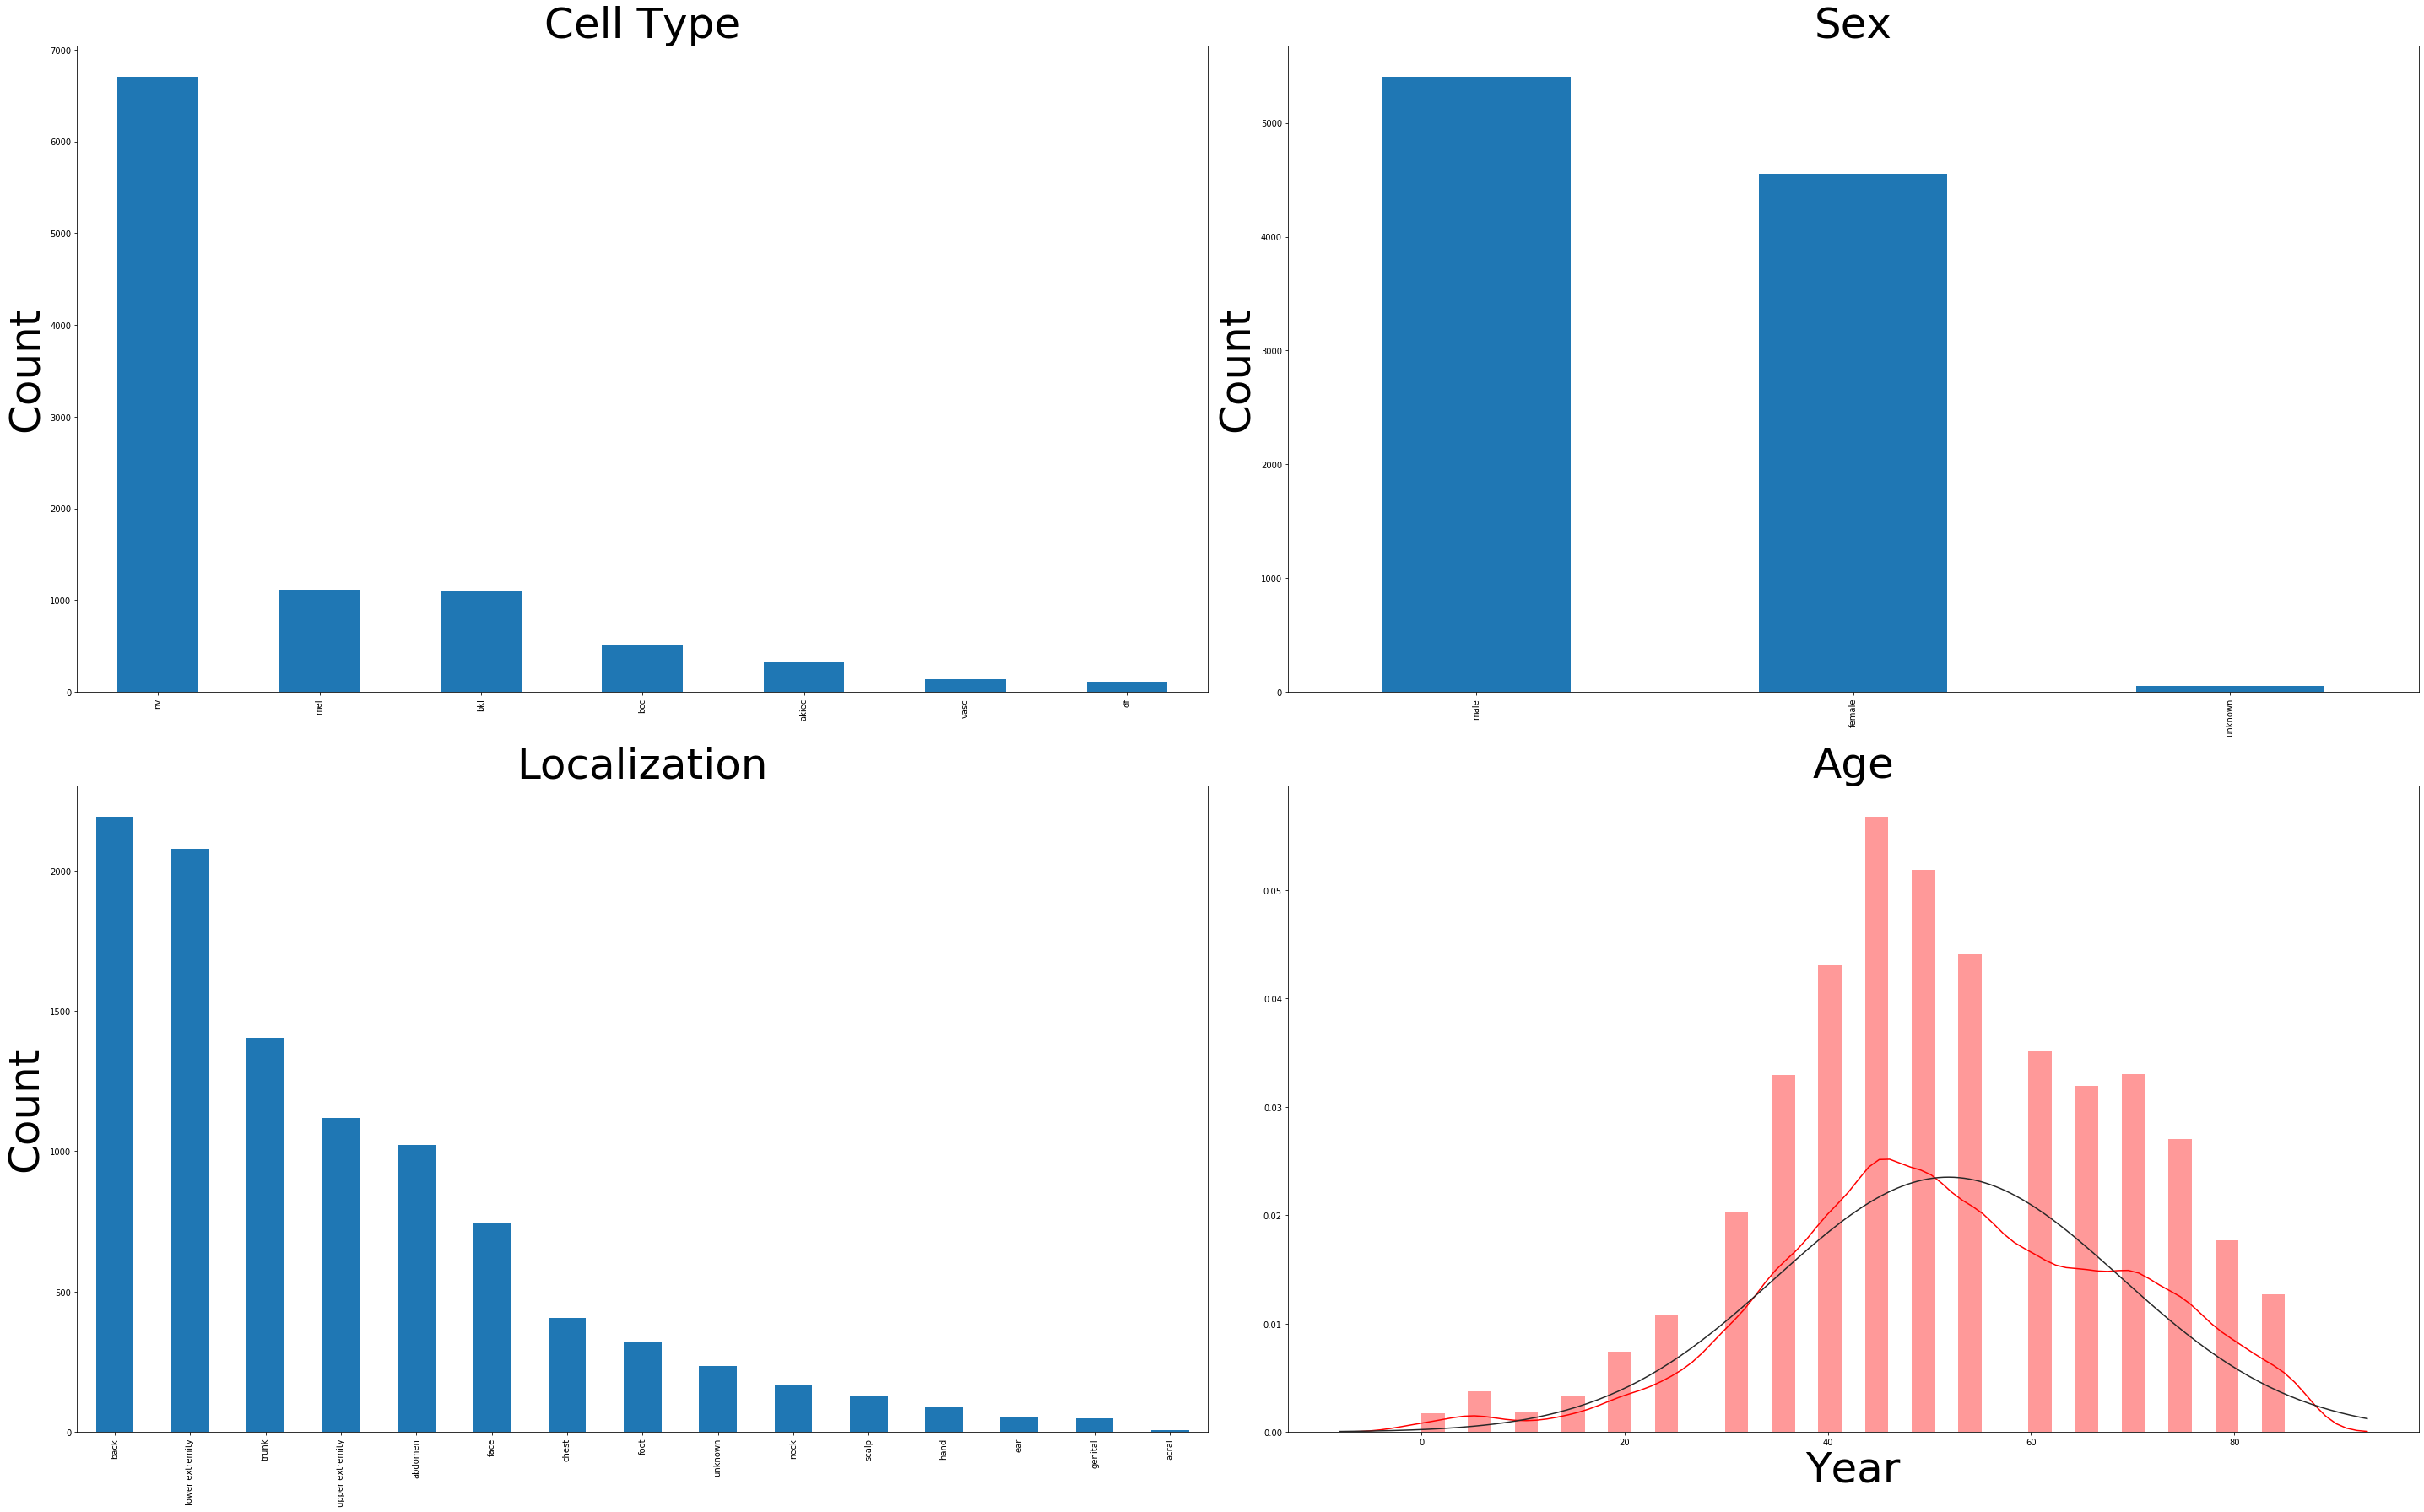

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Getting a sense of what the distribution of each column looks like

fig = plt.figure(figsize=(40,25))

ax1 = fig.add_subplot(221)
metadata['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count', size=50)
ax1.set_title('Cell Type', size = 50)

ax2 = fig.add_subplot(222)
metadata['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=50)
ax2.set_title('Sex', size=50);

ax3 = fig.add_subplot(223)
metadata['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count', size=50)
ax3.set_title('Localization', size=50)


ax4 = fig.add_subplot(224)
sample_age = metadata[pd.notnull(metadata['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age', size = 50)
ax4.set_xlabel('Year', size=50)

plt.tight_layout()
plt.show()

In [5]:

import os
import shutil

# A path to the folder which has all the images:
data_dir = os.getcwd() + "\HAM10000"

# A path to the folder where you want to store the rearranged images:
dest_dir = os.getcwd() + "\HAM10K"

# Read the metadata file:
metadata = pd.read_csv(data_dir + '\HAM10000_metadata.csv')
label = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']
label_images = []

# Copy the images into new folder structure:
for i in label:
    os.mkdir(dest_dir + str(i) + "/")
    sample = metadata[metadata['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[]    


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\srava\\Desktop\\python\\class_6\\HAM10Kbkl/'

In [4]:
import numpy as np

label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']

def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype=np.float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        counts[i] = metadata[metadata['dx']==str(l)]['dx'].value_counts()[0]
    counts = counts.astype(np.float)
    median_freq = np.median(counts)
    for i, label in enumerate(label):
        class_weights[i] = median_freq / counts[i]
    return class_weights

classweight= estimate_weights_mfb(label)
for i in range(len(label)):
    print(label[i],":", classweight[i])

akiec : 1.5718654434250765
bcc : 1.0
bkl : 0.467697907188353
df : 4.469565217391304
mel : 0.4618149146451033
nv : 0.07665920954511558
vasc : 3.619718309859155


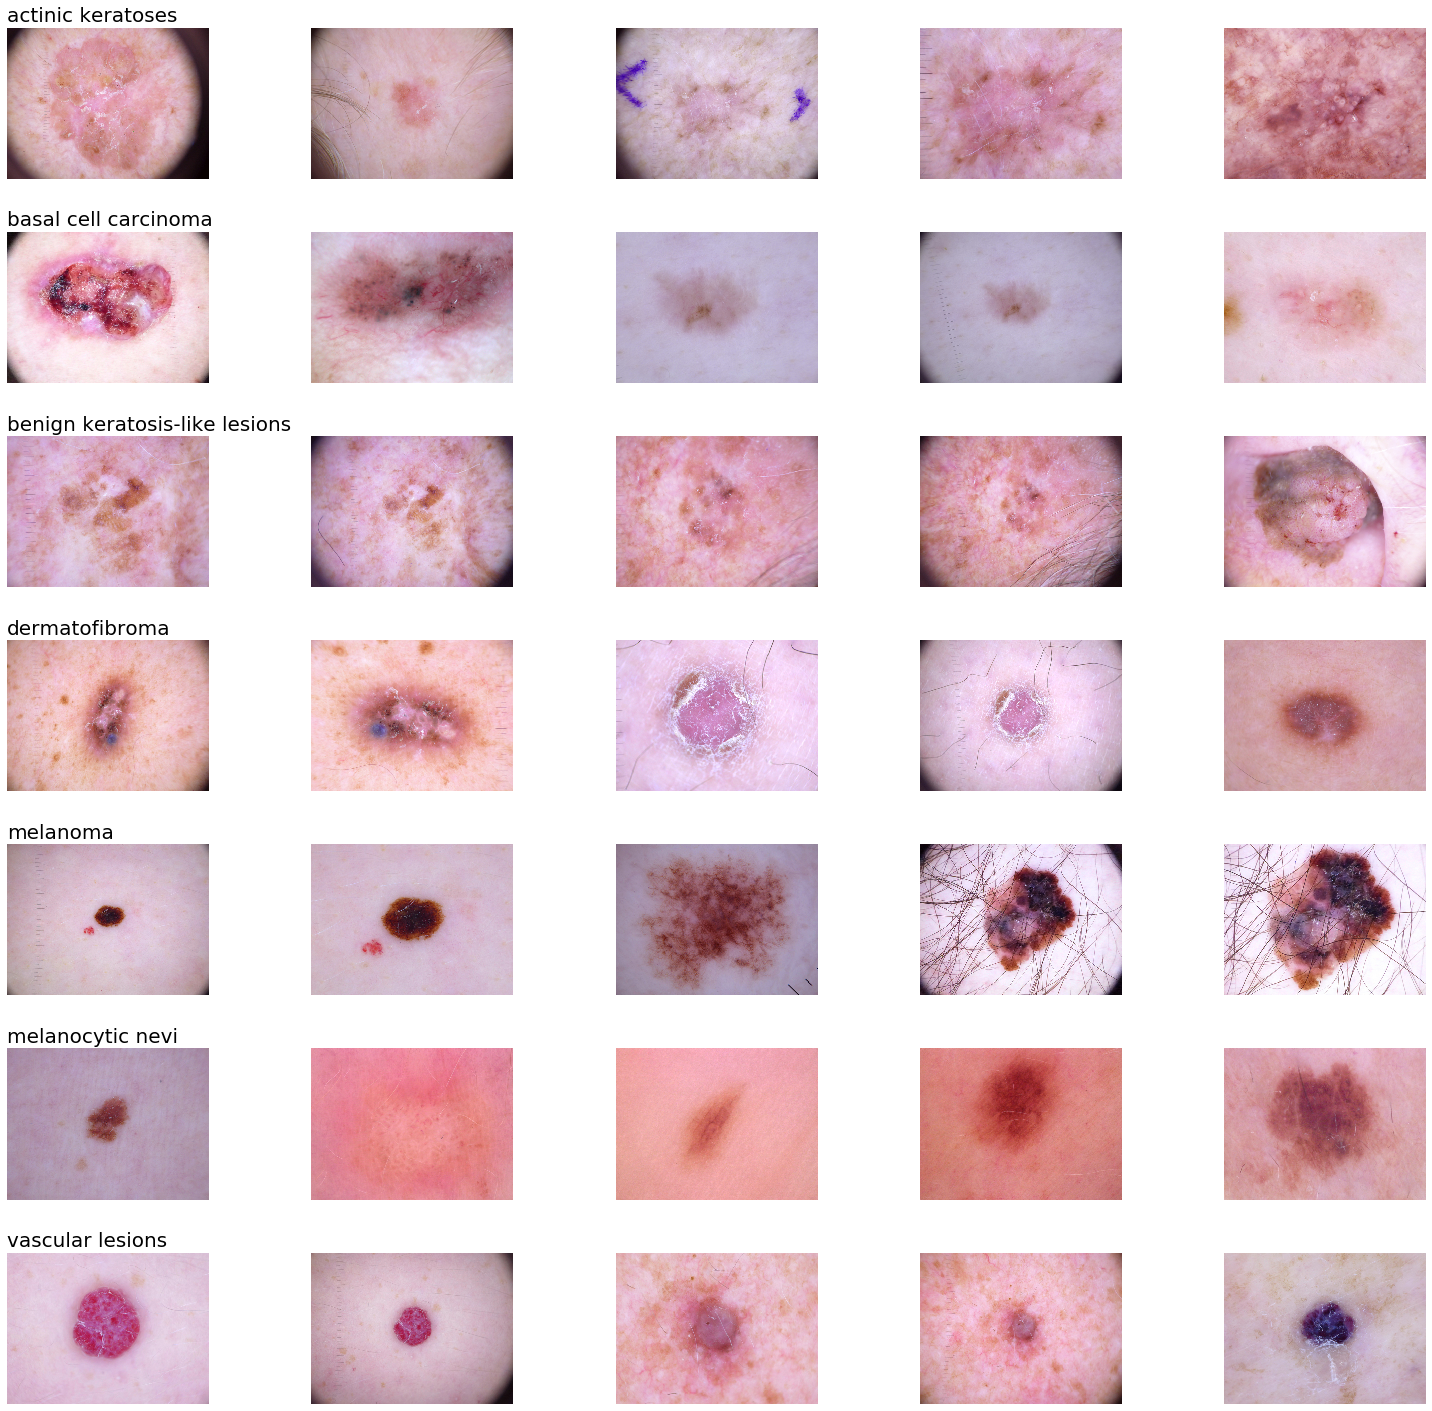

In [5]:
import imageio
from PIL import Image


#Visualizing the images

label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']
label_images = []
classes = [ 'actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions', 
           'dermatofibroma','melanoma', 'melanocytic nevi', 'vascular lesions']

fig = plt.figure(figsize=(20, 20))
k = range(7)

for i in label:
    sample = metadata[metadata['dx'] == i]['image_id'][:5]
    label_images.extend(sample)
    
for position,ID in enumerate(label_images):
    labl = metadata[metadata['image_id'] == ID]['dx']
    im_sample = data_dir + "/"  + ID + '.jpg'
    im_sample = imageio.imread(im_sample)

    plt.subplot(7,5,position+1)
    plt.imshow(im_sample)
    plt.axis('off')

    if position%5 == 0:
        title = int(position/5)
        plt.title(classes[title], loc='left', size=20)

plt.tight_layout()
plt.show()


In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision


data_dir = os.getcwd() + "/HAM10000"

# normalization values for pretrained resnet on Imagenet
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

batch_size = 10
validation_batch_size = 10

# We compute the weights of individual classes and convert them to tensors
class_weights = estimate_weights_mfb(label)
class_weights = torch.FloatTensor(class_weights)

transform_train = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

transform_test = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])


In [7]:

import torch as th
import math

test_size = 0.2
val_size = 0.2
class Sampler(object):
    """Base class for all Samplers.
    """

    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    """Stratified Sampling
    Provides equal representation of target classes
    """
    def __init__(self, class_vector,test_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)
    

dataset = torchvision.datasets.ImageFolder(root= data_dir)
data_label = [s[1] for s in dataset.samples]

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()
# The "pre" is necessary to use array to identify train/ val indices with indices generated by second sampler

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()
indices = {'train': pre_train_indices[train_indices],  # Indices of second sampler are used on pre_train_indices
           'val': pre_train_indices[val_indices],  # Indices of second sampler are used on pre_train_indices
           'test': test_indices
           }

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']
print("Train Data Size:", len(train_indices))
print("Test Data Size:", len(test_indices))
print("Validation Data Size:", len(val_indices))

Train Data Size: 6409
Test Data Size: 2003
Validation Data Size: 1603


In [8]:

SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transform_train)

train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=1, sampler= train_samples)
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples)

dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=test_samples)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actinic keratoses,  basal cell carcinoma,  actinic keratoses,  actinic keratoses,  actinic keratoses,  basal cell carcinoma,  basal cell carcinoma,  basal cell carcinoma,  basal cell carcinoma,  basal cell carcinoma, 


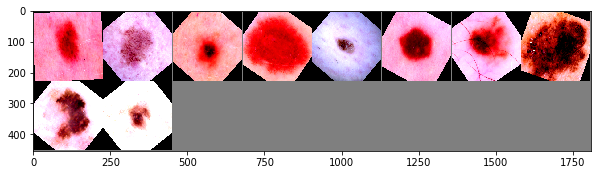

In [9]:

# functions to show an image
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

In [10]:
num_classes = len(classes)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*54*54, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = LeNet()
net = net.to(device)

In [13]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)


In [14]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

In [25]:
# number of loops over the dataset
num_epochs = 30
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 0.619  Accuracy:0.618
Validation Loss: 0.626  Val Accuracy: 0.608
Epoch: 2
Loss: 0.618  Accuracy:0.616
Validation Loss: 0.622  Val Accuracy: 0.619
Epoch: 3
Loss: 0.618  Accuracy:0.617
Validation Loss: 0.624  Val Accuracy: 0.609
Epoch: 4
Loss: 0.616  Accuracy:0.618
Validation Loss: 0.620  Val Accuracy: 0.616
Epoch: 5
Loss: 0.616  Accuracy:0.619
Validation Loss: 0.621  Val Accuracy: 0.623
Epoch: 6
Loss: 0.616  Accuracy:0.616
Validation Loss: 0.632  Val Accuracy: 0.607
Epoch: 7
Loss: 0.617  Accuracy:0.617
Validation Loss: 0.624  Val Accuracy: 0.614
Epoch: 8
Loss: 0.614  Accuracy:0.619
Validation Loss: 0.628  Val Accuracy: 0.609
Epoch: 9
Loss: 0.613  Accuracy:0.617
Validation Loss: 0.619  Val Accuracy: 0.607
Epoch: 10
Loss: 0.614  Accuracy:0.615
Validation Loss: 0.620  Val Accuracy: 0.609
Epoch: 11
Loss: 0.614  Accuracy:0.620
Validation Loss: 0.621  Val Accuracy: 0.611
Epoch: 12
Loss: 0.615  Accuracy:0.622
Validation Loss: 0.624  Val Accuracy: 0.612
Epoch: 13
Loss: 0.614  Ac

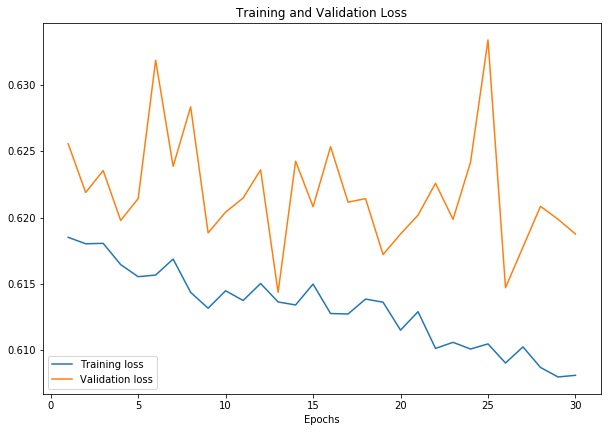

<Figure size 432x288 with 0 Axes>

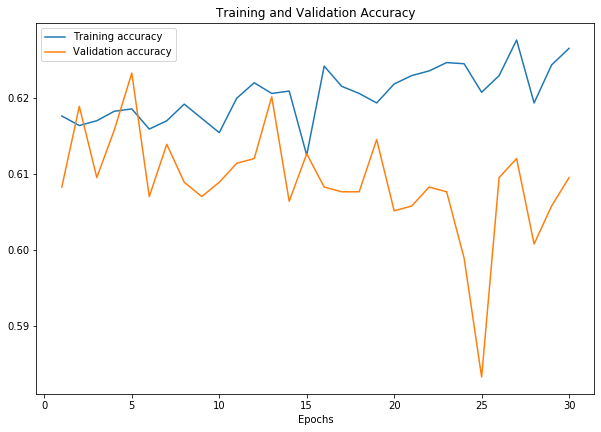

<Figure size 432x288 with 0 Axes>

In [27]:
# plt.plot(losses)
# plt.show()

epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  basal cell carcinoma,   basal cell carcinoma,   actinic keratoses,   basal cell carcinoma,   basal cell carcinoma,   basal cell carcinoma,   basal cell carcinoma,   actinic keratoses,   actinic keratoses,   actinic keratoses,  


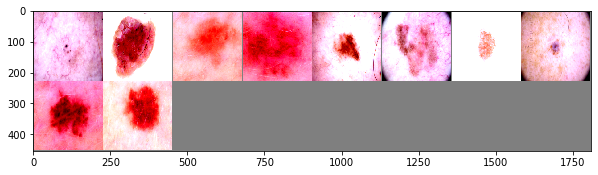

In [28]:
fig = plt.figure(figsize=(10, 15))
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s,  ' % classes[labels[j]] for j in range(len(labels))))

In [29]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 62 %


In [30]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of actinic keratoses : 96 %
Accuracy of basal cell carcinoma : 33 %
Accuracy of benign keratosis-like lesions :  0 %
Accuracy of dermatofibroma :  0 %
Accuracy of melanoma :  0 %
Accuracy of melanocytic nevi :  0 %
Accuracy of vascular lesions :  0 %


In [31]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

cm = confusion_matrix.numpy()

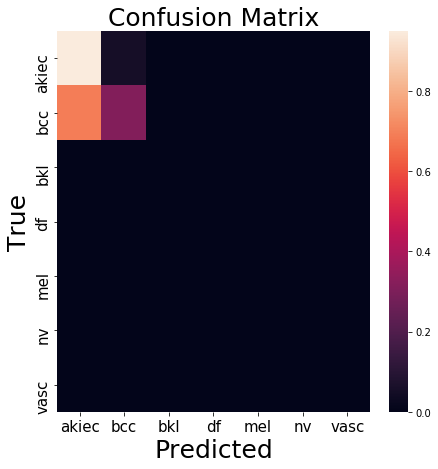

In [32]:
fig,ax= plt.subplots(figsize=(7,7))
sns.heatmap(cm / (cm.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=25);
ax.set_ylabel('True', size=25); 
ax.set_title('Confusion Matrix', size=25); 
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df', 'mel', 'nv','vasc'], size=15); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','mel','nv','vasc'], size=15);

In [38]:
from collections import OrderedDict, Sequence

class _BaseWrapper(object):
    """
    Please modify forward() and backward() according to your task.
    """

    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        """
        Simple classification
        """
        self.model.zero_grad()
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)

    def backward(self, ids):
        """
        Class-specific backpropagation
        Either way works:
        1. self.logits.backward(gradient=one_hot, retain_graph=True)
        2. (self.logits * one_hot).sum().backward(retain_graph=True)
        """

        one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(key):
            def forward_hook_(module, input, output):
                # Save featuremaps
                self.fmap_pool[key] = output.detach()

            return forward_hook_

        def backward_hook(key):
            def backward_hook_(module, grad_in, grad_out):
                # Save the gradients correspond to the featuremaps
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook_

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(forward_hook(name)))
                self.handlers.append(module.register_backward_hook(backward_hook(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)

    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)
        
        return gcam

Generating Grad-CAM @conv2
	#0: basal cell carcinoma (0.51945)


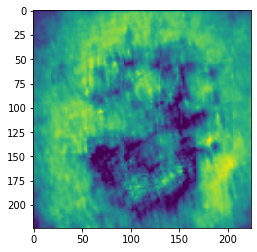

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Class:  basal cell carcinoma


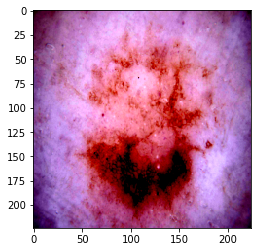

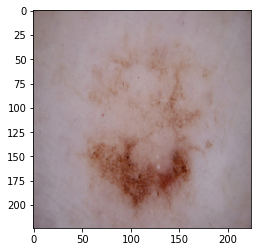

In [39]:
def demo2(image, label, model):
    """
    Generate Grad-CAM
    """
    # Model
    model = model
    model.to(device)
    model.eval()

    # The layers
    target_layers = ["conv2"]
    target_class = label

    # Images
    images = image.unsqueeze(0)
    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)
    ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    gcam.backward(ids=ids_)

    for target_layer in target_layers:
        print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)
        for j in range(len(images)):
            print(
                "\t#{}: {} ({:.5f})".format(
                    j, classes[target_class], float(probs[ids == target_class])
                )
            )
            
            gcam=regions[j, 0]
            plt.imshow(gcam.cpu())
            plt.show()
            
image, label = next(iter(test_data_loader))
# Load the model
model = net
# Grad cam
demo2(image[0].to(device), label[0].to(device), model)


image = np.transpose(image[0], (1,2,0))
image2  = np.add(np.multiply(image.numpy(), np.array(norm_std)) ,np.array(norm_mean))
print("True Class: ", classes[label[0].cpu()])
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()

In [11]:
from torch import nn

num_classes = len(classes)
net = torchvision.models.resnet18(pretrained = True)

# We replace last layer of resnet to match our number of classes which is 7
net.fc = nn.Linear(512, num_classes)
net = net.to(device)

In [12]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

In [ ]:
##### number of loops over the dataset
num_epochs = 70
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

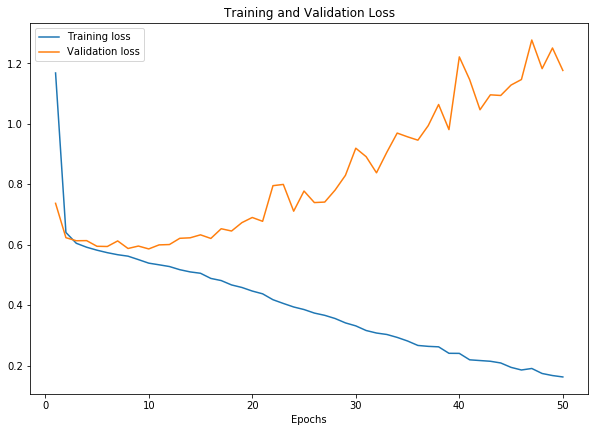

<Figure size 432x288 with 0 Axes>

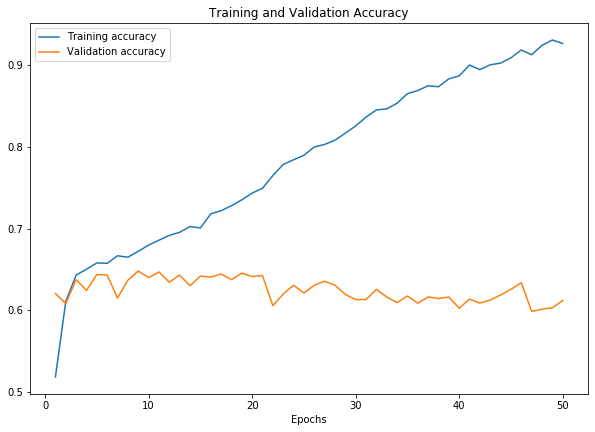

<Figure size 432x288 with 0 Axes>

In [44]:
# plt.plot(losses)
# plt.show()

epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  basal cell carcinoma,   actinic keratoses,   basal cell carcinoma,   basal cell carcinoma,   basal cell carcinoma,   basal cell carcinoma,   actinic keratoses,   actinic keratoses,   actinic keratoses,   actinic keratoses,  


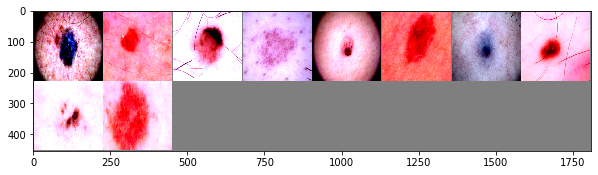

In [45]:
fig = plt.figure(figsize=(10, 15))
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s,  ' % classes[labels[j]] for j in range(len(labels))))

In [46]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 60 %


In [47]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of actinic keratoses : 62 %
Accuracy of basal cell carcinoma : 57 %
Accuracy of benign keratosis-like lesions :  0 %
Accuracy of dermatofibroma :  0 %
Accuracy of melanoma :  0 %
Accuracy of melanocytic nevi :  0 %
Accuracy of vascular lesions :  0 %


In [48]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
net.eval()
with torch.no_grad():
    for data in validation_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of actinic keratoses : 58 %
Accuracy of basal cell carcinoma : 58 %
Accuracy of benign keratosis-like lesions :  0 %
Accuracy of dermatofibroma :  0 %
Accuracy of melanoma :  0 %
Accuracy of melanocytic nevi :  0 %
Accuracy of vascular lesions :  0 %


In [49]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
cm = confusion_matrix.numpy()

tensor([[618., 382.,   0.,   0.,   0.,   0.,   0.],
        [408., 595.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.]])


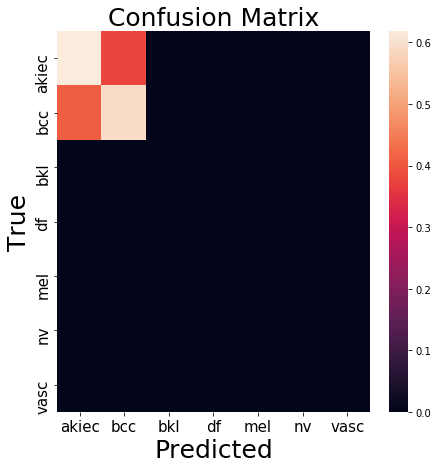

In [50]:
fig,ax= plt.subplots(figsize=(7,7))
sns.heatmap(cm / (cm.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=25);
ax.set_ylabel('True', size=25); 
ax.set_title('Confusion Matrix', size=25); 
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df', 'mel', 'nv','vasc'], size=15); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','mel','nv','vasc'], size=15);

In [51]:
from collections import OrderedDict, Sequence

class _BaseWrapper(object):
    """
    Please modify forward() and backward() according to your task.
    """

    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        """
        Simple classification
        """
        self.model.zero_grad()
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)
    def backward(self, ids):
        """
        Class-specific backpropagation
        Either way works:
        1. self.logits.backward(gradient=one_hot, retain_graph=True)
        2. (self.logits * one_hot).sum().backward(retain_graph=True)
        """

        one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(key):
            def forward_hook_(module, input, output):
                # Save featuremaps
                self.fmap_pool[key] = output.detach()

            return forward_hook_

        def backward_hook(key):
            def backward_hook_(module, grad_in, grad_out):
                # Save the gradients correspond to the featuremaps
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook_

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(forward_hook(name)))
                self.handlers.append(module.register_backward_hook(backward_hook(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)

    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam


Generating Grad-CAM @layer4
	#0: actinic keratoses (0.99986)


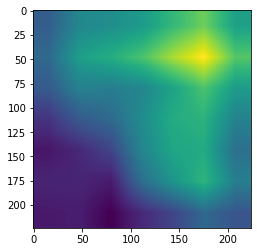

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Class:  actinic keratoses


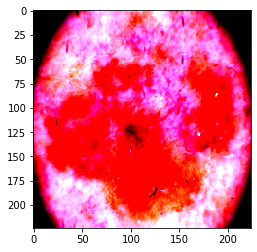

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


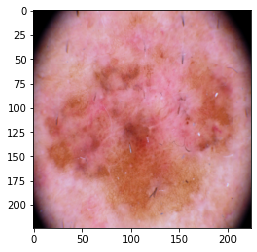

In [52]:
def demo2(image, label, model):
    """
    Generate Grad-CAM
    """
    # Model
    model = model
    model.to(device)
    model.eval()

    # The layers
    target_layers = ["layer4"]
    target_class = label

    # Images
    images = image.unsqueeze(0)
    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)
    ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    gcam.backward(ids=ids_)

    for target_layer in target_layers:
        print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)
        for j in range(len(images)):
            print(
                "\t#{}: {} ({:.5f})".format(
                    j, classes[target_class], float(probs[ids == target_class])
                )
            )
            
            gcam=regions[j, 0]
            plt.imshow(gcam.cpu())
            plt.show()
            
image, label = next(iter(test_data_loader))
# Load the model
model = net
# Grad cam
demo2(image[0].to(device), label[0].to(device), model)

image = np.transpose(image[0], (1,2,0))
image2  = np.add(np.multiply(image.numpy(), np.array(norm_std)) ,np.array(norm_mean))
print("True Class: ", classes[label[0].cpu()])
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()